# 基于PyTorch实现的ViT（Vision Transformer）基础算法

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

## 1. Patch Embedding 模块
将图像分割为patches并进行线性投影

In [2]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        self.img_size = (img_size, img_size)
        self.patch_size = (patch_size, patch_size)
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_chans, embed_dim, 
                             kernel_size=patch_size, 
                             stride=patch_size)

    def forward(self, x):
        # x形状: (B, C, H, W)
        x = self.proj(x)  # 输出形状: (B, E, H/P, W/P)
        x = x.flatten(2)  # 展平后形状: (B, E, N)
        x = x.transpose(1, 2)  # 转置后形状: (B, N, E)
        return x

## 2. 位置编码模块
添加可学习的位置编码

In [3]:
class PositionalEncoding(nn.Module):
    def __init__(self, num_patches, embed_dim):
        super().__init__()
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))  # +1 for cls_token
        
    def forward(self, x):
        return x + self.pos_embed  # 广播相加

## 3. Transformer Encoder 模块
实现多头自注意力和MLP块

In [4]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, int(embed_dim * mlp_ratio)),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(int(embed_dim * mlp_ratio), embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        # 自注意力
        attn_output, _ = self.attn(self.norm1(x), self.norm1(x), self.norm1(x))
        x = x + attn_output
        # MLP
        x = x + self.mlp(self.norm2(x))
        return x

## 4. 完整ViT模型
整合各个模块

In [5]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3,
                 embed_dim=768, depth=12, num_heads=12, mlp_ratio=4.0):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_chans, embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = PositionalEncoding(self.patch_embed.num_patches, embed_dim)
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, mlp_ratio)
            for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        # 生成patch嵌入
        x = self.patch_embed(x)  # (B, N, E)
        
        # 添加cls token
        cls_tokens = self.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)  # (B, N+1, E)
        
        # 添加位置编码
        x = self.pos_embed(x)
        
        # 通过Transformer块
        for block in self.blocks:
            x = block(x)
        
        # 最终层归一化
        x = self.norm(x)
        
        return x[:, 0]  # 返回cls token作为图像表示

## 5. 测试模型
创建示例输入并运行前向传播

In [6]:
if __name__ == "__main__":
    # 参数设置
    img_size = 224
    patch_size = 16
    batch_size = 2
    in_chans = 3
    
    # 创建测试输入
    dummy_img = torch.randn(batch_size, in_chans, img_size, img_size)
    
    # 初始化模型
    vit = VisionTransformer(
        img_size=img_size,
        patch_size=patch_size,
        in_chans=in_chans,
        embed_dim=768,
        depth=12,
        num_heads=12
    )
    
    # 前向传播
    output = vit(dummy_img)
    print(f"输入形状: {dummy_img.shape}")
    print(f"输出形状: {output.shape}")  # 应该得到 (batch_size, embed_dim)

输入形状: torch.Size([2, 3, 224, 224])
输出形状: torch.Size([2, 768])


## 6. 可视化分块效果
展示图像分块过程

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


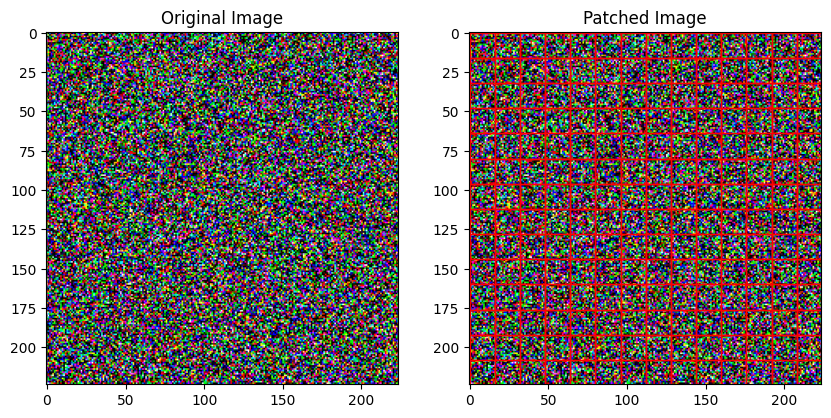

In [7]:
def show_patches(image_tensor, patch_size=16):
    # 转换维度并转为numpy
    image = image_tensor.permute(1, 2, 0).numpy()
    
    # 绘制原始图像
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.title("Original Image")
    
    # 绘制分块图像
    plt.subplot(1,2,2)
    h, w = image.shape[:2]
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            rect = plt.Rectangle((j,i), patch_size, patch_size, linewidth=1, 
                               edgecolor='r', facecolor='none')
            plt.gca().add_patch(rect)
    plt.imshow(image)
    plt.title("Patched Image")
    plt.show()

# 生成测试图像
test_image = torch.randn(3, 224, 224)
show_patches(test_image)